In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1.1 Field & direction normalization

## Concept behind it

### 🧭 1. The Problem: Inconsistent Coordinate Frames

In raw NFL tracking data:

- Each play has a direction (`play_direction`: “left” or “right”).  
- The **x-coordinate** increases toward the right end zone (0 → 120 yards).  
- The **y-coordinate** spans the field width (0 → 53.3 yards).

However:

- Some plays move **leftward**, others **rightward**.  
- That means a player at `x = 20` could be near their own end zone in one play, but near the opponent’s in another.

➡️ The model sees the **same coordinate** but with a **completely different contextual meaning**.

---

### 🧮 2. The Solution: Normalize All Plays to One Direction

We make all plays “move to the right” by flipping the x-axis for leftward plays:

\[
x' = 120 - x
\]

and similarly for the ball landing position:

\[
ball\_land\_x' = 120 - ball\_land\_x
\]

This mirrors the entire play horizontally, so now every play is aligned as if the offense is moving right.

✅ **Benefits**
- The model doesn’t need to learn two different coordinate conventions.  
- It can focus on **patterns of movement**, not on left/right orientation noise.

---

### 🧩 3. Fixing Angles: Orientation and Motion Direction

Angles (`o` and `dir`) are given in **degrees from the x-axis**, so flipping the play reverses facing and motion direction.

We correct this by rotating angles by 180°:

\[
dir' = (dir + 180) \bmod 360
\]

This ensures that a player “running upfield” still runs upfield after flipping the x-axis.

---

### ⚙️ 4. Centering the Field Vertically

In the raw data:

- The **y-coordinate** runs from 0 to 53.3 yards.  
- The middle of the field is `y = 26.65`.

We shift it so that:

\[
y' = y - 26.65
\]

Now, the field runs from −26.65 (bottom sideline) to +26.65 (top sideline).

✅ **Benefits**
- Centering helps neural networks learn **symmetric features** more easily.  
- Distances from the midline are directly interpretable  
  (positive = top half, negative = bottom half).

---

### 🧠 5. The Underlying Concept: Frame Invariance

In ML terms, this normalization enforces **invariance to absolute frame of reference**.

You want your model to focus on **what players are doing**  
(patterns, motion, positioning relative to ball/teammates),  
not **where on the field** or **which direction** they’re moving.

This is analogous to:
- Centering images before feeding them to a CNN  
- Subtracting the mean before PCA  
- Aligning coordinate frames in motion-capture data  

By making all plays look **rightward**, you reduce variance in the input space —  
improving **generalization** and **convergence**.

---

### 🏁 6. Aftermath: Easier Feature Engineering

Once normalized, you can meaningfully compute:

- **Distance to ball:**  
  \(\sqrt{(x - ball\_land\_x)^2 + (y - ball\_land\_y)^2}\)
- **Relative angles:**  
  \((dir - \text{atan2}(y_{diff}, x_{diff}))\)
- **Heatmaps / trajectories** that are visually consistent across plays.

Without normalization, you’d have to treat left and right plays separately —  
doubling data complexity.

---

### ✅ Summary

| Step | Concept | Effect |
|------|----------|---------|
| **Flip x** | Align plays to move right | Consistent field orientation |
| **Rotate angles** | Preserve player facing direction | Consistent motion geometry |
| **Center y** | Midline = 0 | Symmetric learning around field center |
| **Unified frame** | Frame invariance | Simplifies model training & interpretation |

## Code

In [2]:
import pandas as pd
import numpy as np

def normalize_field_direction(df: pd.DataFrame) -> pd.DataFrame:
    """
    Normalizes coordinates, orientation, and direction so that:
      - All plays move toward the right (increasing x).
      - y is centered around 0 (midline = 0).

    Based on Big Data Bowl 2026 dataset format.
    """
    df = df.copy()

    # --- Define mask for left-moving plays ---
    mask_left = df["play_direction"].str.lower() == "left"

    # --- Flip x coordinates for left plays ---
    df.loc[mask_left, "x"] = 120 - df.loc[mask_left, "x"]
    df.loc[mask_left, "ball_land_x"] = 120 - df.loc[mask_left, "ball_land_x"]

    # --- Adjust orientation (o) and movement direction (dir) ---
    for ang_col in ["o", "dir"]:
        if ang_col in df.columns:
            df.loc[mask_left, ang_col] = (df.loc[mask_left, ang_col] + 180) % 360

    # --- Center y around the midline ---
    # The field width is 53.3 yards, so the midline is 26.65
    df["y"] = df["y"] - 26.65
    if "ball_land_y" in df.columns:
        df["ball_land_y"] = df["ball_land_y"] - 26.65

    return df

def normalize_output_like_input(df_out: pd.DataFrame, df_in: pd.DataFrame) -> pd.DataFrame:
    """Flip output x for left plays and center y, using play_direction from input."""
    df_out = df_out.copy()
    dir_map = (df_in[["game_id","play_id","play_direction"]]
               .drop_duplicates()
               .assign(is_left=lambda d: d["play_direction"].str.lower()=="left")
               .drop(columns="play_direction"))
    df_out = df_out.merge(dir_map, on=["game_id","play_id"], how="left")
    df_out.loc[df_out["is_left"]==True, "x"] = 120 - df_out.loc[df_out["is_left"]==True, "x"]
    df_out["y"] = df_out["y"] - 26.65
    return df_out.drop(columns=["is_left"])

In [3]:
import glob
from tqdm import tqdm
import pandas as pd

data_path = "/content/drive/MyDrive/NFL Big Data Bowl 2026/nfl-big-data-bowl-2026-prediction/train"

input_files  = sorted(glob.glob(f"{data_path}/input_2023_w*.csv"))
output_files = sorted(glob.glob(f"{data_path}/output_2023_w*.csv"))

df_in_all  = []
df_out_all = []

for in_f, out_f in tqdm(zip(input_files, output_files), total=len(input_files), desc="Weeks"):
    df_in_raw  = pd.read_csv(in_f)
    df_out_raw = pd.read_csv(out_f)

    # intersect players
    keys = ["game_id", "play_id", "nfl_id"]
    common = (df_out_raw[keys].drop_duplicates()
              .merge(df_in_raw[keys].drop_duplicates(), on=keys, how="inner"))
    df_in_raw  = df_in_raw.merge(common, on=keys, how="inner")
    df_out_raw = df_out_raw.merge(common, on=keys, how="inner")

    # normalize both
    df_in_norm  = normalize_field_direction(df_in_raw)
    df_out_norm = normalize_output_like_input(df_out_raw, df_in_raw)

    df_in_all.append(df_in_norm)
    df_out_all.append(df_out_norm)

df_in_norm  = pd.concat(df_in_all, ignore_index=True)
df_out_norm = pd.concat(df_out_all, ignore_index=True)

print(f"✅ Combined weeks: {df_in_norm['week'].nunique()} weeks, {df_in_norm['game_id'].nunique()} games")

Weeks: 100%|██████████| 18/18 [00:37<00:00,  2.10s/it]


KeyError: 'week'

In [9]:
from tqdm import tqdm

# Graphs built on the throw frame of each play
graphs = build_interaction_graphs(df_in_clean, K=6)

/tmp/ipython-input-1469026939.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.tail(1))
Building KNN graphs per play: 100%|██████████| 14108/14108 [01:04<00:00, 217.99it/s]


In [10]:
import os
import pickle

# Define save path
save_dir = "/content/drive/MyDrive/NFL Big Data Bowl 2026/preprocessed"
os.makedirs(save_dir, exist_ok=True)

# Paths
in_path  = os.path.join(save_dir, "df_in_norm.pkl")
out_path = os.path.join(save_dir, "df_out_norm.pkl")
graph_path = os.path.join(save_dir, "graphs.pkl")

# Save normalized input/output
print("💾 Saving normalized input/output data...")
df_in_norm.to_pickle(in_path)
df_out_norm.to_pickle(out_path)
print(f"✅ Saved df_in_norm → {in_path}")
print(f"✅ Saved df_out_norm → {out_path}")

# Optionally, save graphs too (can be large)
save_graphs = True
if save_graphs:
    print("💾 Saving interaction graphs (this may take a while)...")
    with open(graph_path, "wb") as f:
        pickle.dump(graphs, f)
    print(f"✅ Saved graphs → {graph_path}")

print("🎉 All preprocessing artifacts saved successfully.")

💾 Saving normalized input/output data...
✅ Saved df_in_norm → /content/drive/MyDrive/NFL Big Data Bowl 2026/preprocessed/df_in_norm.pkl
✅ Saved df_out_norm → /content/drive/MyDrive/NFL Big Data Bowl 2026/preprocessed/df_out_norm.pkl
💾 Saving interaction graphs (this may take a while)...
✅ Saved graphs → /content/drive/MyDrive/NFL Big Data Bowl 2026/preprocessed/graphs.pkl
🎉 All preprocessing artifacts saved successfully.


# 1.2 Kinematics & context (per player)

## Concept behind it

### 🧠 Why We Do This

In the **Big Data Bowl 2026 “Prediction”** competition, your model must predict **future player trajectories** — i.e., where everyone will move after the ball is thrown.  
To do that well, your input features must capture:

- **Recent motion trends** (velocity, acceleration, direction)  
- **Immediate game context** (field position, player role, proximity to target)  
- **Stable target geometry** (where the ball is expected to land)

This is exactly what **“Kinematics & Context”** achieves.

---

### ⚙️ 1. Kinematics — Local Motion Physics

You take the **last K frames** (≈ 1 second before the throw) for each player.  
Why? Because recent motion tells us what the player is *about to do*.

| Feature | Meaning | Conceptual Reason |
|----------|----------|------------------|
| `x`, `y` | Absolute position | Defines where the player currently is on the field |
| `vx`, `vy` | Velocity components (Δx/Δt, Δy/Δt) | Shows movement direction and speed trend |
| `s` | Speed magnitude (yards/sec) | Momentum; how fast player is going |
| `a` | Acceleration (yards/sec²) | Change in momentum; player slowing down or bursting |
| `dir` | Motion angle | Heading of movement vector |
| `o` | Body orientation | Which way they’re facing (might differ from motion) |

By averaging or summarizing these over the last **K frames**, you provide your model with a **compressed, noise-resistant description of motion patterns**.  
Think of it as giving the model “instantaneous physics snapshots” — where each player is moving, how fast, and with what intent.

---

### 🎯 2. Goal Features — Direction Toward the Ball’s Landing Spot

At the **throw frame**, you compute:

\[
\Delta x = ball\_land\_x - x
\]
\[
\Delta y = ball\_land\_y - y
\]
\[
\text{Distance} = \sqrt{(\Delta x)^2 + (\Delta y)^2}
\]
\[
\text{Azimuth} = \text{atan2}(\Delta y, \Delta x)
\]

These features tell your model **where the ball is going relative to each player**.

👉 **Why this matters:**
- The **targeted receiver** will run *toward* that point.  
- **Defenders** may run *toward or across* it to intercept.  
- The **passer** is already stationary or retreating.

Thus, the vector from each player to the ball’s landing point provides **strong spatial cues for future movement**.

---

### 🧍 3. Role & Roster Context — Who the Player Is

Each player has categorical roles:

- `player_side` → Offense / Defense  
- `player_role` → Passer, Targeted Receiver, Coverage, etc.  
- `player_position` → WR, CB, LB, QB, etc.  

These are converted to **one-hots or embeddings** so the model “knows” that a QB behaves differently from a WR or CB.

Conceptually, these act like **behavioral priors**:

> “Given this player is a receiver on offense, and their current velocity is 7 yd/s toward the ball landing point, they’ll likely continue accelerating rightward.”

---

### 🏟️ 4. Game Context — Where and When

Two simple but powerful contextual terms:

| Feature | Formula | Meaning |
|----------|----------|---------|
| `abs_yardline_norm` | `absolute_yardline_number / 120` | Field position (0 = own end zone, 1 = opponent end zone) |
| `time_index_norm` | `t / T` (current frame / total) | How far through the play we are |

They let your model reason about **field geometry** (“deep in opponent territory → less field left”)  
and **play timing** (“throw just happened → movement stabilizes soon”).

---

### 🧩 5. The Underlying Principle — Dynamic Context Encoding

Together, these features form a **contextual state vector** for each player:

\[
\mathbf{f}_{player} = [\text{kinematics}_K, \text{goal vector}, \text{role embedding}, \text{game context}]
\]

It’s like giving your model:

> “Here’s who this player is, what they’re currently doing, where they are, and where the ball is going.”

That’s precisely the information a **human coach** would use to predict the next few seconds of motion.

---

### 🧮 6. Why Aggregate Over K Frames?

- Smooths noisy frame-to-frame tracking data  
- Encodes **short-term momentum** rather than instantaneous jitter  
- Provides **temporal memory** for simple models (MLP, XGBoost) that lack sequence awareness  
- For sequence models (LSTM/Transformer), it defines the **input window**

---

### 🏁 Summary

| Block | Concept | What it Teaches the Model |
|--------|----------|---------------------------|
| **Kinematics** | Short-term physics | Direction & motion trend |
| **Goal features** | Spatial intent | Where to move next |
| **Role/Roster** | Behavioral prior | What’s typical for this role |
| **Game context** | Situation awareness | Field position & timing |

---

**In short:**  
You’re translating raw tracking coordinates into a **physics-and-semantics aware description** of the game, enabling your neural model to reason like a football analyst.

## Code

In [5]:
import numpy as np
import pandas as pd

def build_player_kinematics_features(
    df_input: pd.DataFrame,
    K: int = 10
) -> pd.DataFrame:
    """
    Build per-player kinematics and contextual features
    from the last K frames before the ball is thrown.

    Parameters
    ----------
    df_input : pd.DataFrame
        Normalized input tracking data (one week or full train)
    K : int
        Number of frames to include (≈10–12 ~ 1 s)

    Returns
    -------
    pd.DataFrame
        Feature table: one row per (game_id, play_id, nfl_id)
        with aggregated kinematics & context features.
    """

    df = df_input.copy()

    # --- Normalize context columns ---
    df["abs_yardline_norm"] = df["absolute_yardline_number"] / 120.0

    # --- Compute per-frame velocity components ---
    # Ensure proper sorting
    df = df.sort_values(["game_id", "play_id", "nfl_id", "frame_id"])
    df["vx"] = df.groupby(["game_id", "play_id", "nfl_id"])["x"].diff().fillna(0)
    df["vy"] = df.groupby(["game_id", "play_id", "nfl_id"])["y"].diff().fillna(0)

    # --- Select last K frames before throw (per player per play) ---
    def last_k(group):
        return group.tail(K)
    lastK = df.groupby(["game_id", "play_id", "nfl_id"], group_keys=False).apply(last_k)

    # --- Compute goal features at the throw frame (first of those last K) ---
    throw_frame = (
        df.groupby(["game_id", "play_id", "nfl_id"], group_keys=False)
          .apply(lambda g: g.tail(K).head(1))
    )
    throw_frame["dx_land"] = throw_frame["ball_land_x"] - throw_frame["x"]
    throw_frame["dy_land"] = throw_frame["ball_land_y"] - throw_frame["y"]
    throw_frame["dist_land"] = np.sqrt(
        throw_frame["dx_land"]**2 + throw_frame["dy_land"]**2
    )
    throw_frame["az_land"] = np.degrees(
        np.arctan2(throw_frame["dy_land"], throw_frame["dx_land"])
    )

    goal_feats = throw_frame[
        ["game_id", "play_id", "nfl_id", "dx_land", "dy_land", "dist_land", "az_land"]
    ]

    # --- Aggregate kinematics over last K frames ---
    kin_feats = (
        lastK.groupby(["game_id", "play_id", "nfl_id"])
        .agg({
            "x": ["mean", "std"],
            "y": ["mean", "std"],
            "vx": ["mean", "std"],
            "vy": ["mean", "std"],
            "s": ["mean", "std"],
            "a": ["mean", "std"],
            "dir": ["mean"],
            "o": ["mean"],
            "frame_id": ["max"]
        })
        .reset_index()
    )
    kin_feats.columns = ["_".join(col).rstrip("_") for col in kin_feats.columns]

    # --- Merge goal features ---
    feats = kin_feats.merge(goal_feats, on=["game_id", "play_id", "nfl_id"], how="left")

    # --- Add role/roster one-hots or embeddings ---
    roster_cols = ["player_side", "player_role", "player_position"]
    roster = (
        df[["game_id", "play_id", "nfl_id"] + roster_cols]
        .drop_duplicates(["game_id", "play_id", "nfl_id"])
    )

    feats = feats.merge(roster, on=["game_id", "play_id", "nfl_id"], how="left")

    # One-hot encode categorical columns (if you want flat numeric features)
    feats = pd.get_dummies(feats, columns=roster_cols, prefix=roster_cols)

    # --- Add normalized game context ---
    context = (
        df.groupby(["game_id", "play_id", "nfl_id"], as_index=False)
        .agg(abs_yardline_norm=("abs_yardline_norm", "mean"),
             total_frames=("frame_id", "max"))
    )
    feats = feats.merge(context, on=["game_id", "play_id", "nfl_id"], how="left")

    # Normalized time index: t/T = last frame of input / total frames
    feats["time_index_norm"] = feats["frame_id_max"] / feats["total_frames"]

    # Drop redundant helper
    feats.drop(columns=["frame_id_max", "total_frames"], inplace=True)

    return feats

In [ ]:
player_features = build_player_kinematics_features(df_input_norm, K=10)
player_features.head()

/tmp/ipython-input-3623494784.py:40: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lastK = df.groupby(["game_id", "play_id", "nfl_id"], group_keys=False).apply(last_k)
/tmp/ipython-input-3623494784.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.tail(K).head(1))


,game_id,play_id,nfl_id,x_mean,x_std,y_mean,y_std,vx_mean,vx_std,vy_mean,...,player_position_NT,player_position_OLB,player_position_QB,player_position_RB,player_position_S,player_position_SS,player_position_TE,player_position_WR,abs_yardline_norm,time_index_norm
0,2023090700,101,43290,35.326,0.092520,3.433,0.055787,-0.025,0.073824,-0.016,...,False,False,True,False,False,False,False,False,0.35,1.0
1,2023090700,101,44930,49.017,2.250457,-12.423,0.146670,0.730,0.048762,0.039,...,False,False,False,False,False,False,False,True,0.35,1.0
2,2023090700,101,46137,54.353,0.923436,-7.640,0.806281,0.296,0.049710,-0.250,...,False,False,False,False,False,True,False,False,0.35,1.0
3,2023090700,101,52546,47.765,0.377308,-13.637,0.259917,0.128,0.122638,-0.048,...,False,False,False,False,False,False,False,False,0.35,1.0
4,2023090700,101,53487,47.627,1.004103,-2.856,1.241435,0.319,0.045326,-0.399,...,False,False,False,False,False,False,False,False,0.35,1.0


# 1.3 Interaction graph (at throw frame)

## Concept behind it

### 🧠 The Big Idea — From Individual Motion → Collective Interaction

Football is a **multi-agent system** — every player's movement depends on others.  
A receiver cuts because a defender is closing in; the quarterback throws because someone broke free.  

So:

> **Step 1.2** describes *what each player is doing.*  
> **Step 1.3** captures *how players influence one another.*

We model those influences using a **graph**.

---

### 🏈 1️⃣ What Is an Interaction Graph?

At the **throw frame** (when the ball leaves the QB’s hand):

- Each **player = node** with features → `[x, y, vx, vy, role, side, …]`
- Each **edge** connects a player to their **K nearest neighbors** (typically K ≈ 6)

Each edge carries **relative features**:

\[
\Delta x = x_j - x_i,\quad
\Delta y = y_j - y_i,\quad
\Delta v_x = v_{x,j} - v_{x,i},\quad
\Delta v_y = v_{y,j} - v_{y,i}
\]

and a binary `ally_flag` (1 = same team, 0 = opponent).

This shows *who is near whom* and *how they’re moving relative to each other.*

---

### ⚙️ 2️⃣ Why Use a K-NN Graph?

| K | Concept | Effect |
|---|----------|--------|
| ~6 | Connects each player to ~6 closest others | Captures **local spatial dependencies** |
| low K | Too few edges | Misses context |
| high K | Too many edges | Adds noise |

The graph remains **sparse** → efficient for GNN processing.

---

### 🔁 3️⃣ What the Model Learns from This

Once fed into a **Graph Neural Network (GNN)**,  
each node updates its embedding by aggregating information from its neighbors:

| Example | Relationship Learned |
|----------|----------------------|
| WR ↔ CB | Separation or coverage pattern |
| QB ↔ nearest defender | Pocket pressure |
| DB cluster | Zone coordination |
| Offensive teammates | Route spacing patterns |

Each message-passing step teaches the model *how player A’s motion affects player B.*

---

### 🧩 4️⃣ Edge Feature Intuition

| Feature | Meaning | Intuition |
|----------|----------|-----------|
| Δx, Δy | Relative position | Who’s close to whom |
| Δvx, Δvy | Relative motion | Closing speed or separation |
| ally_flag | Team relationship | Cooperation vs competition |

This lets the model tell *“two allies = blocking,”*  
*“two opponents = coverage or chase.”*

---

### 🕐 5️⃣ Why the Throw Frame?

The **throw frame** is a causal anchor — the instant that defines all post-throw trajectories.

It captures:
- Offensive routes at the moment of release  
- Defensive alignment and reaction  
- Ball target location (from Step 1.2)

That frozen snapshot is the best summary of **game state at decision time.**

---

### 🧮 6️⃣ Mathematical View

Each play graph  
\[
G = (V, E)
\]
with  

\[
V_i = [x_i, y_i, v_{x,i}, v_{y,i}, \text{role}_i, \text{side}_i, …], \quad
E_{ij} = [\Delta x_{ij}, \Delta y_{ij}, \Delta v_{x,ij}, \Delta v_{y,ij}, \text{ally}_{ij}]
\]

The GNN layer updates:

\[
h_i' = \sigma\!\left(W_1 h_i + \sum_{j\in N(i)} f_\theta(E_{ij})\,W_2 h_j\right)
\]

so each player’s embedding encodes **context from neighbors.**

---

### ⚡ 7️⃣ Practical Uses

| Task | How Interaction Graph Helps |
|------|-----------------------------|
| Trajectory Prediction | Adds spatial awareness & crowd influence |
| Target Receiver ID | Highlights separation vs coverage |
| Coverage Analysis | Reveals defensive zone shapes |
| Visualization | Draw edges → intuitive field heatmaps |

---

### 🏁 8️⃣ Summary

| Concept | Meaning | Why It Matters |
|----------|----------|----------------|
| **Interaction Graph** | Local K-NN graph of players at throw time | Captures multi-agent dependencies |
| **Edge Features** | Δx, Δy, Δvx, Δvy, ally_flag | Encode relative geometry + motion |
| **Throw Frame** | Snapshot when ball is released | Defines post-throw evolution |
| **Caching** | Store per-play graphs | Enables fast GNN inference |
| **Downstream Use** | GraphConv, EdgeConv, GAT | Learns team and opponent interactions |

---

> 🧩 **Step 1.3 turns your normalized, physics-aware data into a relational graph.**  
> It teaches your model to see football not as 22 dots moving around — but as **22 interacting agents playing a game.**

## Code

In [8]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm

def build_interaction_graphs(df_input: pd.DataFrame, K: int = 6):
    """
    Build K-NN interaction graphs per play at the throw frame.
    Each graph connects every player to K nearest neighbors
    with edge features [dx, dy, dvx, dvy, ally_flag].

    Returns
    -------
    dict[(game_id, play_id)] = {
        "nodes": pd.DataFrame of player features,
        "edges": pd.DataFrame of edge features
    }
    """

    df = df_input.copy()

    # ------------------------------------------------------------------
    # 🧭 1️⃣ Ensure velocity columns exist
    # ------------------------------------------------------------------
    if "vx" not in df.columns or "vy" not in df.columns:
        df = df.sort_values(["game_id", "play_id", "nfl_id", "frame_id"]).copy()
        df["vx"] = df.groupby(["game_id", "play_id", "nfl_id"])["x"].diff().fillna(0)
        df["vy"] = df.groupby(["game_id", "play_id", "nfl_id"])["y"].diff().fillna(0)

    # ------------------------------------------------------------------
    # 🕐 2️⃣ Extract throw frame (last frame of input for each player)
    # ------------------------------------------------------------------
    throw_frame = (
        df.groupby(["game_id", "play_id", "nfl_id"], group_keys=False)
          .apply(lambda g: g.tail(1))
          .reset_index(drop=True)
    )

    # ------------------------------------------------------------------
    # 🧩 3️⃣ Build graph per play
    # ------------------------------------------------------------------
    graphs = {}
    plays = throw_frame.groupby(["game_id", "play_id"])

    for (gid, pid), play_df in tqdm(plays, desc="Building KNN graphs per play"):

        # node features (one per player)
        nodes = play_df[
            ["nfl_id", "x", "y", "vx", "vy", "player_side", "player_role"]
        ].reset_index(drop=True)

        coords = nodes[["x", "y"]].values

        if len(nodes) < 2:
            continue  # skip incomplete plays

        # Fit KNN (K+1 to include self, drop self edge later)
        nbrs = NearestNeighbors(
            n_neighbors=min(K + 1, len(nodes)),
            algorithm="ball_tree"
        ).fit(coords)
        distances, indices = nbrs.kneighbors(coords)

        edge_records = []
        for i, nbr_idxs in enumerate(indices):
            for j in nbr_idxs[1:]:  # skip self
                src = nodes.iloc[i]
                dst = nodes.iloc[j]
                edge_records.append({
                    "src_id": src["nfl_id"],
                    "dst_id": dst["nfl_id"],
                    "dx": dst["x"] - src["x"],
                    "dy": dst["y"] - src["y"],
                    "dvx": dst["vx"] - src["vx"],
                    "dvy": dst["vy"] - src["vy"],
                    "ally_flag": 1 if src["player_side"] == dst["player_side"] else 0
                })

        edges = pd.DataFrame(edge_records)
        graphs[(gid, pid)] = {"nodes": nodes, "edges": edges}

    return graphs

In [ ]:
graphs = build_interaction_graphs(df_input_norm, K=6)

# Inspect one play
g, p = list(graphs.keys())[0]
play_graph = graphs[(g, p)]

print("Nodes:", play_graph["nodes"].shape)
print("Edges:", play_graph["edges"].shape)
play_graph["edges"].head()

/tmp/ipython-input-1469026939.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.tail(1))
Building KNN graphs per play: 100%|██████████| 819/819 [00:12<00:00, 65.88it/s]

Nodes: (9, 7)
Edges: (54, 7)


,src_id,dst_id,dx,dy,dvx,dvy,ally_flag
0,43290,53487,13.77,-7.99,0.31,-0.34,0
1,43290,53959,15.19,6.44,0.41,-0.11,1
2,43290,54486,14.17,11.97,0.38,0.05,0
3,43290,53541,11.44,-16.68,0.03,-0.63,1
4,43290,52546,12.60,-17.55,-0.10,-0.24,0


In [ ]:
g, p = list(graphs.keys())[0]
graphs[(g, p)]["edges"].head(10)

,src_id,dst_id,dx,dy,dvx,dvy,ally_flag
0,43290,53487,13.77,-7.99,0.31,-0.34,0
1,43290,53959,15.19,6.44,0.41,-0.11,1
2,43290,54486,14.17,11.97,0.38,0.05,0
3,43290,53541,11.44,-16.68,0.03,-0.63,1
4,43290,52546,12.60,-17.55,-0.10,-0.24,0
5,43290,54527,21.82,5.60,0.17,-0.18,0
6,44930,52546,-4.42,-1.70,-0.83,-0.15,0
7,44930,46137,3.39,3.53,-0.41,-0.25,0
8,44930,53541,-5.58,-0.83,-0.70,-0.54,1
9,44930,53487,-3.25,7.86,-0.42,-0.25,0


In [ ]:
play = graphs[(g, p)]
play["nodes"]["player_side"].value_counts()

,count
player_side,
Defense,5
Offense,4


In [ ]:
play["edges"]["ally_flag"].value_counts(normalize=True)

,proportion
ally_flag,
0,0.574074
1,0.425926


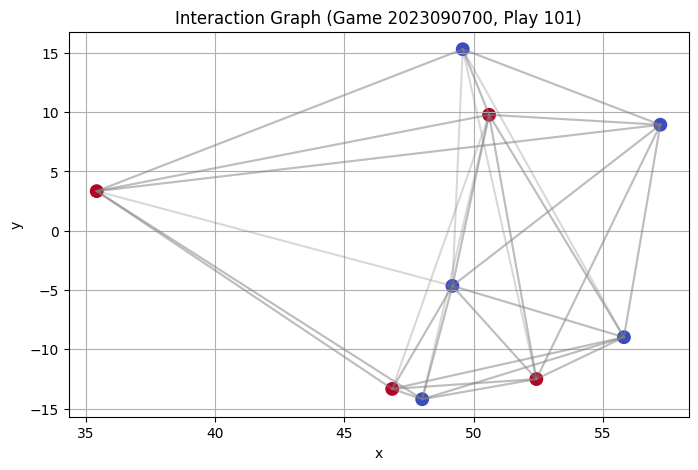

In [ ]:
import matplotlib.pyplot as plt

nodes = play["nodes"]
edges = play["edges"]

plt.figure(figsize=(8,5))
plt.scatter(nodes["x"], nodes["y"], c=(nodes["player_side"]=="Offense"), cmap="coolwarm", s=80)
for _, e in edges.iterrows():
    src = nodes.loc[nodes["nfl_id"] == e["src_id"]]
    dst = nodes.loc[nodes["nfl_id"] == e["dst_id"]]
    plt.plot([src["x"].values[0], dst["x"].values[0]],
             [src["y"].values[0], dst["y"].values[0]],
             color="gray", alpha=0.3)
plt.title(f"Interaction Graph (Game {g}, Play {p})")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()

In [ ]:
# easily cache to disk for reuse during training/inference
import pickle

with open("/content/interaction_graphs.pkl", "wb") as f:
    pickle.dump(graphs, f)

# Later
# with open("/content/interaction_graphs.pkl", "rb") as f:
#     graphs = pickle.load(f)

# 1.4 Variable players & horizons

## Concept behind it

### 🧠 The Problem — Real Games Aren’t Uniform

In the NFL tracking data, every play is different:

- The number of **tracked players (P)** can vary.  
  → Some players move off-screen or aren’t captured.  
- The number of **frames to predict (N)** also varies.  
  → Different plays end sooner or later.

But neural networks (especially GNNs or Transformers) need **fixed-size tensors** for batching.

\[
P_i \neq P_j,\; N_i \neq N_j \;\Rightarrow\; \text{variable shapes} \;\text{→ can’t batch directly.}
\]

So we introduce a simple rule:

> Fix a **maximum player count** `P_max = 22` and a **maximum prediction horizon** `N_max = 30`,  
> and then **pad + mask** to make every play the same shape.

---

### ⚙️ 1️⃣ Padding Players

Each play graph might have 18–22 visible players.  
We pad up to `P_max = 22` with zeros.

| Case | Action |
|------|---------|
| 9 players visible | pad 13 “empty” player slots |
| 21 players visible | pad 1 slot |
| 22 players visible | no padding |

This ensures `x ∈ ℝ^[batch, P_max, features]`.

---

### 🕐 2️⃣ Padding Prediction Horizons

Each player has its own **num_frames_output** (how many frames to predict).  
We fix a global limit `N_max = 30` and pad trajectories to this length.

| Player | num_frames_output | Resulting length |
|---------|-------------------|------------------|
| WR1 | 27 | 27 valid + 3 padded |
| CB1 | 30 | full |
| LB1 | 18 | 18 valid + 12 padded |

This creates `horizon_mask[i, j] = 1` for valid timesteps, `0` for padded ones.

---

### 🧩 3️⃣ Masks — Telling the Model What’s Real

Two types of masks control learning:

| Mask | Shape | Purpose |
|------|--------|----------|
| **player_mask** | `[batch, P_max]` | 1 = player exists, 0 = padding |
| **horizon_mask** | `[batch, P_max, N_max]` | 1 = frame valid for that player |

These masks make sure your loss and attention ignore padded entries.

---

### ⚙️ 4️⃣ Why Masks Matter

Without masking, the model would learn meaningless correlations from zero-padded players or timesteps.  
With masking, the network only focuses on **real data**.

Example loss:
\[
\text{Loss} = \frac{\sum (y_\text{pred}-y_\text{true})^2 \times \text{horizon\_mask}}{\sum \text{horizon\_mask}}
\]

So the model only learns from existing frames and players.

---

### 🧠 5️⃣ The Concept of “Fixed Capacity”

Think of this like resizing images for CNNs —  
we make every input “fit” a consistent shape while marking which parts are empty.

| Concept | Analogy |
|----------|----------|
| Padding players | Add blank pixels around an image |
| Masking players | Ignore blank pixels during convolution |
| Padding horizons | Extend sequence to fixed length |
| Masking horizons | Stop gradient beyond end of play |

---

### 🏁 6️⃣ Summary

| Concept | Meaning | Why It Matters |
|----------|----------|----------------|
| **P_max = 22** | Max players per play | Standardizes graph size |
| **N_max = 30** | Max frames to predict | Fixes sequence length |
| **Padding** | Adds zeros for missing data | Enables batching |
| **Masks** | Mark valid players/frames | Prevents learning noise |
| **Outcome** | Uniform tensors for model input | Compatible with GNN + sequence models |

---

> ⚡ **Step 1.4 makes your pipeline batchable and reliable.**  
> It converts messy, real-world football tracking data into clean, fixed-shape tensors your model can learn from —  
> while keeping the variability of real games safely masked out.

## Code

In [ ]:
import numpy as np
import torch

def prepare_padded_batch(df_input: pd.DataFrame,
                         graphs: dict,
                         P_max: int = 22,
                         N_max: int = 30):
    """
    Prepare padded tensors for variable player counts and horizons.

    Parameters
    ----------
    df_input : pd.DataFrame
        Normalized tracking input (with num_frames_output)
    graphs : dict
        Output of build_interaction_graphs()
    P_max : int
        Max number of players per play (pad to this)
    N_max : int
        Max number of frames to predict (pad to this)

    Returns
    -------
    batch = {
        'x': torch.Tensor [B, P_max, F],
        'edge_index': list of torch.LongTensor (per-play edges),
        'edge_attr': list of torch.FloatTensor (per-play edges),
        'player_mask': torch.BoolTensor [B, P_max],
        'horizon_mask': torch.FloatTensor [B, P_max, N_max]
    }
    """

    plays = sorted(graphs.keys())
    X_list, edge_index_list, edge_attr_list = [], [], []
    player_masks, horizon_masks = [], []

    for (gid, pid) in plays:
        play_graph = graphs[(gid, pid)]
        nodes = play_graph["nodes"]

        # -------------------------------
        # 1️⃣ Player node features
        # -------------------------------
        node_feats = nodes[["x", "y", "vx", "vy"]].values
        n_players = node_feats.shape[0]

        # Pad to P_max
        pad_len = P_max - n_players
        if pad_len > 0:
            node_feats = np.vstack([node_feats, np.zeros((pad_len, node_feats.shape[1]))])

        # -------------------------------
        # 2️⃣ Edge structure
        # -------------------------------
        edges = play_graph["edges"]
        if len(edges) > 0:
            edge_index = torch.tensor(edges[["src_id", "dst_id"]].values.T.copy(), dtype=torch.long)
            edge_attr = torch.tensor(edges[["dx", "dy", "dvx", "dvy", "ally_flag"]].values, dtype=torch.float)
        else:
            edge_index = torch.zeros((2, 0), dtype=torch.long)
            edge_attr = torch.zeros((0, 5), dtype=torch.float)

        # -------------------------------
        # 3️⃣ Masks
        # -------------------------------
        player_mask = np.zeros(P_max)
        player_mask[:n_players] = 1

        # Get horizon per player
        horizon = (
            df_input.query("game_id == @gid and play_id == @pid")
            .groupby("nfl_id")["num_frames_output"].max()
            .reindex(nodes["nfl_id"]).fillna(0).to_numpy()
        )

        horizon_mask = np.zeros((P_max, N_max))
        for i, h in enumerate(horizon[:P_max]):
            horizon_mask[i, :int(min(h, N_max))] = 1

        X_list.append(node_feats)
        edge_index_list.append(edge_index)
        edge_attr_list.append(edge_attr)
        player_masks.append(player_mask)
        horizon_masks.append(horizon_mask)

    # -------------------------------
    # 4️⃣ Convert to torch tensors
    # -------------------------------
    batch = {
        "x": torch.tensor(np.stack(X_list), dtype=torch.float),              # [B, P_max, F]
        "edge_index": edge_index_list,                                       # list of [2, E]
        "edge_attr": edge_attr_list,                                         # list of [E, 5]
        "player_mask": torch.tensor(np.stack(player_masks), dtype=torch.bool),  # [B, P_max]
        "horizon_mask": torch.tensor(np.stack(horizon_masks), dtype=torch.float)  # [B, P_max, N_max]
    }

    return batch

In [ ]:
batch = prepare_padded_batch(df_input_norm, graphs, P_max=22, N_max=30)

print("x:", batch["x"].shape)
print("player_mask:", batch["player_mask"].shape)
print("horizon_mask:", batch["horizon_mask"].shape)
print("edge_index[0]:", batch["edge_index"][0].shape)
print("edge_attr[0]:", batch["edge_attr"][0].shape)

x: torch.Size([819, 22, 4])
player_mask: torch.Size([819, 22])
horizon_mask: torch.Size([819, 22, 30])
edge_index[0]: torch.Size([2, 54])
edge_attr[0]: torch.Size([54, 5])


# 1.5 Cleaning & augmentation

## Concept behind it

## Code

In [6]:
import pandas as pd
import numpy as np
from scipy.signal import medfilt

def clean_and_augment(df: pd.DataFrame,
                      spike_thresh: float = 8.0,
                      smooth_window: int = 3,
                      jitter_pos: float = 0.1,
                      jitter_angle: float = 2.0,
                      dropout_prob: float = 0.05,
                      augment_mirror: bool = True) -> pd.DataFrame:
    """
    Step 1.5 - Clean and augment tracking data.

    Operations:
    1. Drop tracking spikes (> 8 yds in one frame)
    2. Apply 3-point median smoothing on x, y for last few input frames
    3. Augment: mirror across centerline, add small jitter, occasional dropout

    Parameters
    ----------
    df : pd.DataFrame
        Normalized tracking dataframe (after Step 1.1)
    spike_thresh : float
        Max allowed movement (yards/frame)
    smooth_window : int
        Median filter window size for smoothing jitter
    jitter_pos : float
        Random position noise magnitude (yards)
    jitter_angle : float
        Random orientation noise magnitude (degrees)
    dropout_prob : float
        Probability of dropping a non-scored player
    augment_mirror : bool
        Whether to create mirrored copies across centerline

    Returns
    -------
    pd.DataFrame
        Cleaned (and possibly augmented) tracking dataframe
    """

    df = df.copy()

    # ---------------------------------------------------------
    # 1️⃣ Drop tracking spikes
    # ---------------------------------------------------------
    df = df.sort_values(["game_id", "play_id", "nfl_id", "frame_id"])
    df["dx"] = df.groupby(["game_id", "play_id", "nfl_id"])["x"].diff()
    df["dy"] = df.groupby(["game_id", "play_id", "nfl_id"])["y"].diff()
    df["dist_move"] = np.sqrt(df["dx"]**2 + df["dy"]**2)

    n_spikes = (df["dist_move"] > spike_thresh).sum()
    print(f"⚠️ Removed {n_spikes} frame spikes (> {spike_thresh} yds).")

    df = df[df["dist_move"] <= spike_thresh].drop(columns=["dx", "dy", "dist_move"])

    # ---------------------------------------------------------
    # 2️⃣ Apply 3-point median filter to reduce jitter
    # ---------------------------------------------------------
    def median_smooth(group):
        group = group.sort_values("frame_id")
        group["x"] = medfilt(group["x"], kernel_size=smooth_window)
        group["y"] = medfilt(group["y"], kernel_size=smooth_window)
        return group

    df = df.groupby(["game_id", "play_id", "nfl_id"], group_keys=False).apply(median_smooth)

    # ---------------------------------------------------------
    # 3️⃣ Data Augmentation
    # ---------------------------------------------------------
    aug_dfs = []

    # 3a. Mirror augmentation (flip across y=0)
    if augment_mirror:
        mirror_df = df.copy()
        mirror_df["y"] = -mirror_df["y"]
        if "dir" in mirror_df.columns:
            mirror_df["dir"] = (360 - mirror_df["dir"]) % 360
        if "o" in mirror_df.columns:
            mirror_df["o"] = (360 - mirror_df["o"]) % 360
        mirror_df["aug_type"] = "mirror"
        aug_dfs.append(mirror_df)

    # 3b. Tiny random jitter (positional + angular)
    jitter_df = df.copy()
    jitter_df["x"] += np.random.uniform(-jitter_pos, jitter_pos, size=len(jitter_df))
    jitter_df["y"] += np.random.uniform(-jitter_pos, jitter_pos, size=len(jitter_df))
    if "dir" in jitter_df.columns:
        jitter_df["dir"] += np.random.uniform(-jitter_angle, jitter_angle, size=len(jitter_df))
    if "o" in jitter_df.columns:
        jitter_df["o"] += np.random.uniform(-jitter_angle, jitter_angle, size=len(jitter_df))
    jitter_df["aug_type"] = "jitter"
    aug_dfs.append(jitter_df)

    # 3c. Occasional non-scored player dropout
    dropout_df = df.copy()
    mask_dropout = (dropout_df["player_to_predict"] == False) & (
        np.random.rand(len(dropout_df)) < dropout_prob
    )
    dropout_df = dropout_df[~mask_dropout]
    dropout_df["aug_type"] = "dropout"
    aug_dfs.append(dropout_df)

    # ---------------------------------------------------------
    # Combine originals + augmentations
    # ---------------------------------------------------------
    df["aug_type"] = "original"
    df_aug = pd.concat([df] + aug_dfs, ignore_index=True)
    df_aug = df_aug.sort_values(["game_id", "play_id", "nfl_id", "frame_id"]).reset_index(drop=True)

    print(f"✅ Augmented dataset created: {df_aug['aug_type'].value_counts().to_dict()}")
    return df_aug

In [7]:
df_in_clean = clean_and_augment(df_in_norm,
                                spike_thresh=8.0,
                                smooth_window=3,
                                jitter_pos=0.1,
                                jitter_angle=2.0,
                                dropout_prob=0.05,
                                augment_mirror=True)

⚠️ Removed 0 frame spikes (> 8.0 yds).


/tmp/ipython-input-939410601.py:67: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(["game_id", "play_id", "nfl_id"], group_keys=False).apply(median_smooth)


✅ Augmented dataset created: {'original': 1257395, 'mirror': 1257395, 'jitter': 1257395, 'dropout': 1257395}
